In [1]:
import numpy as np
from tensorflow.keras import Model as Model_
from tensorflow.keras.layers import Input, ReLU, LSTM, Dense, TimeDistributed, Bidirectional, Normalization, GaussianNoise 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow_model_remediation.min_diff.losses.mmd_loss as MMD
import tensorflow_model_remediation.min_diff.losses.adjusted_mmd_loss as adjustedMMD

print(tf.keras.__version__)

2.9.0


In [ ]:
#Need only to be used with google colab
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow_model_remediation

In [2]:
import os
import re

class Dataset_Preprocessing:
    def __init__(self, dir_path, include_dimension = 2, sample_size = 50, total_classes = 17, datatype = 'float32'):
        
        #Dataset Directory path
        self.dir_path = dir_path
        
        #Which Dimension file to include, possible values: 2 and 3
        self.include_dimension = include_dimension
        
        #Total frames in one Sample
        self.sample_size = sample_size
        
        #Default Datatype for all the samples
        self.datatype = datatype
        
        #Activity classes to include
        self.classes = ['SittingDown', 'Walking', 'Directions', 'Discussion', 'Sitting', 'Phoning', 'Eating', 'Posing', 'Greeting', 'Smoking']
        
        #Total activity classes
        self.total_classes = len(self.classes)
        
        #Subject Folders names in the Dataset
        self.internal_folders = ['S1', 'S5','S6','S7','S8','S9','S11']
    
    def read_dataset(self):
        try:
            #Contains all the different activity vectors
            activity_vector = {}
            
            #Contains the overall dataset
            sampled_data = None
            
            #Based on dimensions, which folder to use for extracting the dataset files
            data_folder = 'Poses_D2_Positions' if self.include_dimension == 2 else 'Poses_D3_Positions'
            
            #Checking if the dataset path is valid
            if not os.path.exists(self.dir_path):
                print('The Data Directory Does not Exist!')
                return None

            #Iterating over all the subject folders
            for fld in self.internal_folders:
                #Iterating for each file in the specified folder
                for file in os.listdir(os.path.join(self.dir_path, fld, data_folder)):
                    #Extracting the activity from the filename
                    activity = self.__extract_activity(file)
                    
                    if activity not in self.classes:
                        continue
                    
                    #Reading the CSV file using Pandas
                    data = pd.read_csv(os.path.join(self.dir_path, fld, data_folder, file), header=None)

                    #Formulating the activity vector using one hot encoding
                    if activity not in activity_vector:
                        total_keys = len(activity_vector.keys())
                        activity_vector[activity] = np.zeros(self.total_classes)
                        activity_vector[activity][total_keys] = 1
                    vector = activity_vector[activity]
                    
                    #Sampling the dataset
                    grouped_sample = self.__group_samples(data, self.sample_size, vector)
                    sampled_data = grouped_sample if sampled_data is None else np.append(sampled_data, grouped_sample, axis=0)
            
            #Changing the Datatype
            sampled_data = sampled_data.astype(self.datatype)
            
            return sampled_data
        except Exception as e:
            print(e)
    
    def __extract_activity(self, filename):
        try:
            #Extracting the filename and excluding the extension
            name = os.path.splitext(filename)[0]
            
            #Substituting the empty string with characters other than english alphabets
            activity = re.sub('[^A-Za-z]+' , '' , name)
            return activity
        except Exception as e:
            print(e)
    
    def __group_samples(self, dataset, sample_size, activity):
        try:
            #Checking if the dataset is a Pandas Dataframe
            if not isinstance(dataset, pd.DataFrame):
                print('Expecting Pandas Dataframe, but got {}'.format(type(dataset)))
                return None
            
            #Appending activity class to each row in the dataset
            dataset = pd.concat([dataset, pd.DataFrame(np.tile(activity, (dataset.shape[0],1)))], axis=1)
            
            #Reshaping the dataset into sample batches
            total_samples = dataset.shape[0]//sample_size
            total_features = dataset.shape[1]
            grouped_rows = dataset.to_numpy()[:total_samples*self.sample_size].reshape((-1,self.sample_size, total_features))
            
            return grouped_rows
        except Exception as e:
            print(e)

In [3]:
#For long term prediction, we need a sample size of 60(10 frames input sequance, 50 frames predicted sequance)
sampled_data = Dataset_Preprocessing('./H3.6csv', sample_size=60).read_dataset()

## Splitting dataset to features and labels

In [4]:
def split_to_features_labels(dataset, input_sequance_size=10) :
    """
    Function for splitting the data into features(with sequance size=iput_sequance_size)
    and labels which should be the remainder of the sample length 
    """
    assert input_sequance_size < dataset.shape[1], f"input sequance should be smaller than the total sample size"
    features = dataset[:, np.s_[0:input_sequance_size], :]
    labels = dataset[:,np.s_[input_sequance_size:], :64]
    
    return features, labels

In [5]:
#To make the data divisible for batch size of 20
total_batches = sampled_data.shape[0]
sampled_data = sampled_data[:total_batches-(total_batches%20)]

In [6]:
sampled_dataX, sampled_dataY = split_to_features_labels(sampled_data, input_sequance_size=10)

In [7]:
print('Total Samples: {}'.format(sampled_dataY.shape[0]))
print('Total Frames: {}'.format(sampled_dataY.shape[1]))
print('Total Features: {}'.format(sampled_dataY.shape[2]))

Total Samples: 25520
Total Frames: 50
Total Features: 64


## Adding Preprocessing steps to improve model performance and robustness

### Downsampling the Samples

In [8]:
def downsampling(sampled_data, downsample_technique = 'skip'):
    """
    The function used to down-sample the data using two different techniques. In Skip, one frame is skipped consecutively and
    in the mean technique, two frames are averaged consecutively.
    """
    samples_per_batch = int(sampled_data.shape[1] / 2)
    total_features = sampled_data.shape[2]
    downsampled_data = np.empty(shape=(0, samples_per_batch, total_features))
    
    if downsample_technique == 'skip':
        downsampled_data = sampled_data[:,::2,:]
    else:
        for batch in sampled_data:
            averaged_batch = np.empty(shape=(0, total_features))
            for i in range(0, batch.shape[0], 2):
                averaged_batch = np.append(averaged_batch, np.mean(batch[i:i+2, :], axis = 0).reshape((1, total_features)), axis = 0)
            downsampled_data = np.append(downsampled_data, averaged_batch.reshape((1, samples_per_batch, total_features)), axis = 0)
    return downsampled_data

In [9]:
def preprocess_data(sampled_dataX, sampled_dataY, normalize=True, add_noise=True, stddev=0.05) :
    """
    Function to preprocess data by normalizing input features and adding guassian
    noise to increase model robustness
    """  
    if normalize :
        sampled_dataX =  tf.keras.utils.normalize(sampled_dataX, axis=2)
    if add_noise :
        guassian_noise_layer = tf.keras.layers.GaussianNoise(stddev=stddev)
        sampled_dataX = guassian_noise_layer(sampled_dataX)
    return sampled_dataX, sampled_dataY

In [10]:
preprocessed_sampled_dataX, preprocessed_sampled_dataY = preprocess_data(sampled_dataX, sampled_dataY) 

In [11]:
downsampled_data = downsampling(sampled_data, 'skip')

In [12]:
downsampled_dataX, downsampled_dataY = split_to_features_labels(downsampled_data, input_sequance_size=10)
preprocessed_downsampled_dataX, preprocessed_downsampled_dataY = preprocess_data(downsampled_dataX, downsampled_dataY) 

## Defining different components of the model

In [13]:
class InterpolationLayer(tf.keras.layers.Layer):
    """
    Custom interpolation layer extending the keras layer class
    it has one attribute num_frames to be interpolated between each two consecutive 
    timesteps
    it has one main function interpolateFrames  
    """
  
    def __init__(self, num_frames=5):
        super(InterpolationLayer, self).__init__()
        self.num_frames = num_frames
       
    def interpolateFrames(self, inputs):
        """
        Takes input tensors of shape(batch_size, timesteps, features)
        returns interpolated frames with shape(batch_size, timesteps*num_frames, features)
        """
        batch_size = inputs.shape[0]
        timesteps = inputs.shape[1]
        features = inputs.shape[2]
        interpolated_frames = tf.zeros([0, features])

        for batch in range(batch_size) :
            for t in range(timesteps) :
                for j in range(self.num_frames) :
                    X_i0 = inputs[batch, t]
                    if(t == timesteps-1) :
                        X_i1 = inputs[batch, t]
                    else :  
                        X_i1 = inputs[batch, t+1]
                    alpha_j = j/self.num_frames
                    current_frame = alpha_j*X_i0 + (1-alpha_j)*X_i1
                    current_frame = tf.reshape(current_frame, [1, features])
                    interpolated_frames = tf.concat((interpolated_frames, current_frame), axis=0)

        interpolated_frames = tf.reshape(interpolated_frames, [batch_size, (timesteps)*self.num_frames, features])
        return interpolated_frames

    def call(self, inputs):
        return self.interpolateFrames(inputs)

In [14]:
class GlocalNet(Model_):
    """
    A full GlocalNet implementation include the three main stages
    Glogen generating initial sparse frames
    Interpolation layer generating dense frames from Glogen output
    Locgen generating the final output by smoothing the interpolated frames
    """
    def __init__(self, enocder_hidden_state=200, decoder_hidden_state=200, 
                 output_diminsion=64, LSTM_dropout=0.25, dense_activation='relu',
                 interpolation_frames=5, exclude_locgen=False):
        super(GlocalNet, self).__init__()
        self.exclude_locgen = exclude_locgen
        #Glogen layers
        self.glogen_encoder = LSTM(enocder_hidden_state, return_state=True
                                   , return_sequences=True, dropout=LSTM_dropout)
        self.glogen_decoder = LSTM(decoder_hidden_state, return_sequences=True,
                                   return_state=True, dropout=LSTM_dropout)
        #Locgen layers
        self.locgen_encoder = LSTM(enocder_hidden_state, return_sequences=True,
                                   return_state=True, dropout=LSTM_dropout)
        self.locgen_decoder = LSTM(decoder_hidden_state, return_sequences=True,
                                   return_state=True, dropout=LSTM_dropout)
        #Glogen dense layer
        self.glogen_dense_layer = TimeDistributed(Dense(output_diminsion,
                                                        activation=dense_activation)) 
        #Interpolation layer
        self.interpolation_layer = InterpolationLayer(num_frames=interpolation_frames)
        #Locgen dense layer
        self.locgen_dense_layer = TimeDistributed(Dense(output_diminsion,
                                                        activation=dense_activation)) 
        
    def call(self, inputs):
        #Glogen calls      
        encoder_outputs, state_h, state_c = self.glogen_encoder(inputs)
        encoder_states = [state_h, state_c]
        output, _, _ = self.glogen_decoder(encoder_outputs, initial_state=encoder_states)
        glogen_output = self.glogen_dense_layer(output)

        #Interpolation call
        interpolated_frames = self.interpolation_layer(glogen_output)
        
        if self.exclude_locgen :
            return interpolated_frames

        #Locgen calls
        locgen_encoder_outputs, locgen_state_h, locgen_state_c = self.locgen_encoder(interpolated_frames)
        locgen_encoder_states = [locgen_state_h, locgen_state_c]
        locgen_output, _, _ = self.locgen_decoder(locgen_encoder_outputs, initial_state=locgen_encoder_states)
        final_output = self.locgen_dense_layer(locgen_output)
        return final_output

In [15]:
class JointLoss() :
    """
    Joint loss class with two weight attributes for two different losses
    first one is the loss joint and the second is the loss_motion_flow
    """
    def __init__(self, lambda1=0.5, lambda2=0.5, mmd_kernel='gaussian') :
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.mmd_kernel = mmd_kernel

    def loss_joint(self, predicted_sequance_batch, target_sequance_batch) :
        """
        Loss between the joint positions and its corresponding counterparts in the groundtruth
        """
        diff_norm_2 = tf.math.reduce_sum(tf.square(tf.subtract(predicted_sequance_batch, target_sequance_batch)), axis=2)
        return tf.reduce_sum(diff_norm_2, axis=1) 

    def loss_motion_flow(self, predicted_sequance_batch, target_sequance_batch) :
        """
        Loss between the motion flow of predicted sequance and the ground truth
        where the motion flow is the euclidean distance between each two consecutive frames
        """
        predictions_tomporal_diffs = tf.experimental.numpy.diff(predicted_sequance_batch, axis=1)
        real_tomporal_diffs = tf.experimental.numpy.diff(target_sequance_batch, axis=1)
        prediction_motion_flow_diff_norm_2 = tf.reduce_sum(tf.square(tf.subtract(predictions_tomporal_diffs, real_tomporal_diffs)), axis=2)
        return tf.reduce_sum(prediction_motion_flow_diff_norm_2, axis=1)


    def total_loss(self, target_sequance_batch, predicted_sequance_batch) :
        """
        calculating the total loss through a combination of the joint_loss and motion_flow_loss
        """
        joints_loss = self.loss_joint(predicted_sequance_batch, target_sequance_batch)
        motion_flow_loss = self.loss_motion_flow(predicted_sequance_batch, target_sequance_batch)
        return self.lambda1*joints_loss + self.lambda2*motion_flow_loss

    def custom_sequence_MMD_loss(self, target_sequance_batch, predicted_sequance_batch):
        """
        Calculating the Sequence MMD Loss between prediction and the ground Truth.
         Additionally combining the last two dimensions 
        """
        mmd_loss = MMD.MMDLoss(kernel=self.mmd_kernel)
        total_batches = predicted_sequance_batch.shape[0]
        frames_per_batch = predicted_sequance_batch.shape[1] * predicted_sequance_batch.shape[2]
        return mmd_loss(tf.reshape(predicted_sequance_batch, [total_batches, frames_per_batch]),
                        tf.reshape(target_sequance_batch, [total_batches, frames_per_batch]))

## Running experiment with different hyperparameters

In [32]:
def run_experiment(sampled_dataX, sampled_dataY, learning_rate=0.002, lambda1=0.5,
                   lambda2=0.5, use_mse=False, use_MMD=False, metrics=None,
                   batch_size=100, epochs=50, validation_split=0.2, activation="relu",
                   dropout=0.25, exclude_locgen=False, interpolate_frames = 5) :
    """
    Method takes all hyperparameters as input paramters and returns the model and history as
    a result
    """
    glocal_model = GlocalNet(dense_activation=activation, LSTM_dropout=dropout,
                             exclude_locgen=exclude_locgen, interpolation_frames = interpolate_frames)
    if use_mse :
        loss_function = tf.keras.losses.mean_squared_error
    elif use_MMD :
        loss_function = JointLoss().custom_sequence_MMD_loss
    else :
        loss_function = JointLoss(lambda1=lambda1, lambda2=lambda2).total_loss

    glocal_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                       loss=loss_function, metrics=metrics)
    history = glocal_model.fit(sampled_dataX, sampled_dataY,
                              batch_size=batch_size,
                              epochs=epochs, validation_split=validation_split)
    return history, glocal_model

## Experiment Running for MSE and joint loss

In [17]:
history_mse, glocal_model_mse = run_experiment(sampled_dataX, sampled_dataY, epochs=10, 
                                               use_mse=True, validation_split=0.0,
                                               batch_size=20, dropout=0.0,
                                               metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/10
1276/1276 [==============================] - 342s 209ms/step - loss: 106904.7812 - mean_absolute_percentage_error: 56.2039
Epoch 2/10
1276/1276 [==============================] - 264s 207ms/step - loss: 30513.5723 - mean_absolute_percentage_error: 23.5763
Epoch 3/10
1276/1276 [==============================] - 265s 208ms/step - loss: 27432.4473 - mean_absolute_percentage_error: 22.4088
Epoch 4/10
1276/1276 [==============================] - 265s 207ms/step - loss: 27421.8906 - mean_absolute_percentage_error: 22.4447
Epoch 5/10
1276/1276 [==============================] - 265s 207ms/step - loss: 27422.8105 - mean_absolute_percentage_error: 22.4478
Epoch 6/10
1276/1276 [==============================] - 266s 208ms/step - loss: 27424.5762 - mean_absolute_percentage_error: 22.4538
Epoch 7/10
1276/1276 [==============================] - 270s 212ms/step - loss: 27424.1348 - mean_absolute_percentage_error: 22.4491
Epoch 8/10
1276/1276 [==============================] - 266s 208ms/s

In [18]:
history_jointLoss, glocal_model_jointLoss = run_experiment(sampled_dataX, sampled_dataY, epochs=10, 
                                                           lambda1=0.5, lambda2=0.5, validation_split=0.0,
                                                           batch_size=20, dropout=0.0,
                                                           metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/10
1276/1276 [==============================] - 319s 210ms/step - loss: 159290336.0000 - mean_absolute_percentage_error: 54.1721
Epoch 2/10
1276/1276 [==============================] - 267s 209ms/step - loss: 29314212.0000 - mean_absolute_percentage_error: 20.0524
Epoch 3/10
1276/1276 [==============================] - 584s 458ms/step - loss: 23970064.0000 - mean_absolute_percentage_error: 18.8663
Epoch 4/10
1276/1276 [==============================] - 689s 540ms/step - loss: 23963464.0000 - mean_absolute_percentage_error: 18.8958
Epoch 5/10
1276/1276 [==============================] - 308s 241ms/step - loss: 23954730.0000 - mean_absolute_percentage_error: 18.9114
Epoch 6/10
1276/1276 [==============================] - 275s 216ms/step - loss: 23952396.0000 - mean_absolute_percentage_error: 18.9197
Epoch 7/10
1276/1276 [==============================] - 277s 217ms/step - loss: 23953500.0000 - mean_absolute_percentage_error: 18.9220
Epoch 8/10
1276/1276 [=========================

## Running experiment with MMD

In [19]:
history_mmd, glocal_model_mmd = run_experiment(sampled_dataX, sampled_dataY, epochs=10, 
                                               use_mse=True, validation_split=0.0,
                                               batch_size=20, dropout=0.0,
                                               metrics=[JointLoss().custom_sequence_MMD_loss,
                                                        tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/10
1276/1276 [==============================] - 340s 219ms/step - loss: 101695.4688 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 54.8955
Epoch 2/10
1276/1276 [==============================] - 281s 220ms/step - loss: 21887.8906 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 21.1720
Epoch 3/10
1276/1276 [==============================] - 304s 238ms/step - loss: 18643.6797 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 19.9711
Epoch 4/10
1276/1276 [==============================] - 324s 254ms/step - loss: 18629.8809 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 20.0053
Epoch 5/10
1276/1276 [==============================] - 322s 252ms/step - loss: 18632.0918 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 20.0130
Epoch 6/10
1276/1276 [==============================] - 290s 227ms/step - loss: 18632.3281 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error:

In [20]:
history_low_learning_rate, glocal_low_learning_rate = run_experiment(sampled_dataX, sampled_dataY, epochs=15, 
                                                                     use_mse=True, learning_rate=0.0005, validation_split=0.0,
                                                                     batch_size=20, dropout=0.0,
                                                                     metrics=[JointLoss().custom_sequence_MMD_loss, 
                                                                              tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/15
1276/1276 [==============================] - 357s 226ms/step - loss: 192679.7656 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 86.6784
Epoch 2/15
1276/1276 [==============================] - 287s 225ms/step - loss: 121112.6094 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 63.7301
Epoch 3/15
1276/1276 [==============================] - 286s 224ms/step - loss: 76994.1797 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 45.4688
Epoch 4/15
1276/1276 [==============================] - 285s 223ms/step - loss: 52473.2070 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 33.6978
Epoch 5/15
1276/1276 [==============================] - 288s 225ms/step - loss: 41279.4219 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 28.0725
Epoch 6/15
1276/1276 [==============================] - 286s 224ms/step - loss: 37684.4453 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error

In [21]:
#Running MMD with laplacian kernel
history_laplacian, glocal_model_laplacian = run_experiment(sampled_dataX, sampled_dataY, epochs=10, 
                                                           use_mse=True, validation_split=0.0,
                                                           batch_size=20, dropout=0.0,
                                                           metrics=[JointLoss(mmd_kernel="laplacian").custom_sequence_MMD_loss,
                                                                    tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/10
1276/1276 [==============================] - 340s 222ms/step - loss: 98099.7656 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 54.4614
Epoch 2/10
1276/1276 [==============================] - 282s 221ms/step - loss: 15513.4570 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 19.9811
Epoch 3/10
1276/1276 [==============================] - 283s 221ms/step - loss: 12093.3916 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 18.7132
Epoch 4/10
1276/1276 [==============================] - 281s 220ms/step - loss: 12078.9902 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 18.7472
Epoch 5/10
1276/1276 [==============================] - 281s 220ms/step - loss: 12080.1641 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 18.7579
Epoch 6/10
1276/1276 [==============================] - 282s 221ms/step - loss: 12077.4541 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 

## Running Experiment with preprocessing

### Without Downsampling

In [22]:
history_preprocessed, glocal_model_preprocessed = run_experiment(preprocessed_sampled_dataX, preprocessed_sampled_dataY,
                                                                 batch_size=20, dropout=0.0,
                                                                 epochs=50, use_mse=True, 
                                                                 metrics=[JointLoss().custom_sequence_MMD_loss,
                                                                          tf.keras.losses.mean_absolute_percentage_error], 
                                                                 validation_split=0.0)

Epoch 1/50
1276/1276 [==============================] - 333s 220ms/step - loss: 102243.4297 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 54.8054
Epoch 2/50
1276/1276 [==============================] - 283s 221ms/step - loss: 22807.3809 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 21.3080
Epoch 3/50
1276/1276 [==============================] - 286s 224ms/step - loss: 19574.1797 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 20.1709
Epoch 4/50
1276/1276 [==============================] - 293s 230ms/step - loss: 19563.6543 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 20.2226
Epoch 5/50
1276/1276 [==============================] - 298s 234ms/step - loss: 19563.9805 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 20.2183
Epoch 6/50
1276/1276 [==============================] - 295s 231ms/step - loss: 19564.6504 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error:

In [23]:
history_interpolation_only, glocal_interpolation_only = run_experiment(preprocessed_sampled_dataX, preprocessed_sampled_dataY,
                                                                       batch_size=20, dropout=0.0, exclude_locgen=True,
                                                                       epochs=50, use_mse=True, 
                                                                       metrics=[JointLoss().custom_sequence_MMD_loss,
                                                                                tf.keras.losses.mean_absolute_percentage_error], 
                                                                       validation_split=0.0)

Epoch 1/50
1276/1276 [==============================] - 319s 192ms/step - loss: 113417.9297 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 58.3448
Epoch 2/50
1276/1276 [==============================] - 243s 190ms/step - loss: 40860.0938 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 27.8470
Epoch 3/50
1276/1276 [==============================] - 239s 187ms/step - loss: 37959.8750 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 26.9271
Epoch 4/50
1276/1276 [==============================] - 246s 193ms/step - loss: 37954.3594 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 26.9771
Epoch 5/50
1276/1276 [==============================] - 225s 176ms/step - loss: 37954.8828 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 26.9749
Epoch 6/50
1276/1276 [==============================] - 217s 170ms/step - loss: 37955.5938 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error:

### With Downsampling

In [33]:
history_preprocessed, glocal_model_preprocessed = run_experiment(preprocessed_downsampled_dataX, preprocessed_downsampled_dataY,
                                                                 batch_size=20, dropout=0.0,
                                                                 epochs=50, use_mse=True, 
                                                                 metrics=[JointLoss().custom_sequence_MMD_loss,
                                                                          tf.keras.losses.mean_absolute_percentage_error], 
                                                                 validation_split=0.0, interpolate_frames = 2)

Epoch 1/50
1276/1276 [==============================] - 156s 101ms/step - loss: 104523.2422 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 56.6736
Epoch 2/50
1276/1276 [==============================] - 133s 104ms/step - loss: 25759.8691 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 23.7290
Epoch 3/50
1276/1276 [==============================] - 132s 103ms/step - loss: 22486.5449 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 22.4776
Epoch 4/50
1276/1276 [==============================] - 134s 105ms/step - loss: 22474.7441 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 22.5231
Epoch 5/50
1276/1276 [==============================] - 134s 105ms/step - loss: 22474.8770 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 22.5234
Epoch 6/50
1276/1276 [==============================] - 134s 105ms/step - loss: 22476.1328 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error:

In [34]:
history_interpolation_only, glocal_interpolation_only = run_experiment(preprocessed_downsampled_dataX, preprocessed_downsampled_dataY,
                                                                       batch_size=20, dropout=0.0, exclude_locgen=True,
                                                                       epochs=50, use_mse=True, 
                                                                       metrics=[JointLoss().custom_sequence_MMD_loss,
                                                                                tf.keras.losses.mean_absolute_percentage_error], 
                                                                       validation_split=0.0, interpolate_frames = 2)

Epoch 1/50
1276/1276 [==============================] - 106s 64ms/step - loss: 102362.4844 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 55.6589
Epoch 2/50
1276/1276 [==============================] - 83s 65ms/step - loss: 23386.0957 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 22.3700
Epoch 3/50
1276/1276 [==============================] - 83s 65ms/step - loss: 20204.5078 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 21.1436
Epoch 4/50
1276/1276 [==============================] - 83s 65ms/step - loss: 20193.9922 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 21.1928
Epoch 5/50
1276/1276 [==============================] - 83s 65ms/step - loss: 20195.3789 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 21.1889
Epoch 6/50
1276/1276 [==============================] - 82s 64ms/step - loss: 20195.5820 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 21.1916
Ep

In [ ]:
predictions = glocal_model_preprocessed(sampled_dataX[:500])

In [52]:
predictions = glocal_interpolation_only(sampled_dataX[:1000])

In [53]:
predictions_sum = np.sum(np.reshape(predictions, (1000, 50*64)), axis=1)

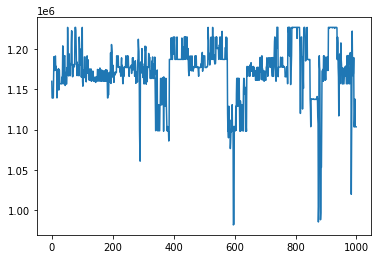

In [54]:
plt.plot(np.arange(0,1000), predictions_sum)